In [1]:
import os
for dirname, _, _ in os.walk('/kaggle/input'):
        print(os.path.join(dirname))

/kaggle/input
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/siim-isic-melanoma-classification/test
/kaggle/input/melanoma-image-insights


In [2]:
import math
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm import tqdm_notebook as tqdm

import gc
%matplotlib inline

In [3]:
print("The version of Tensorflow used  = {}".format(tf.__version__))
print("The version of OpenCV used = {}".format(cv2.__version__))

The version of Tensorflow used  = 2.2.0
The version of OpenCV used = 4.3.0


# Defining Path To Images : 

In [4]:
path_train = "/kaggle/input/siim-isic-melanoma-classification/jpeg/train/"
path_test = "/kaggle/input/siim-isic-melanoma-classification/jpeg/test/"

In [5]:
images_in_training_path = os.listdir(path_train)
images_in_testing_path = os.listdir(path_test)

print("Number Of images in training path = {}".format(len(images_in_training_path)))
print("Number of images in testing path = {}".format(len(images_in_testing_path)))

Number Of images in training path = 33126
Number of images in testing path = 10982


In [6]:
train = pd.DataFrame(pd.read_csv("/kaggle/input/melanoma-image-insights/updated_training_file"))
test = pd.DataFrame(pd.read_csv("/kaggle/input/melanoma-image-insights/updated_test_file"))

print("Shape Of training file = {}".format(train.shape))
print("Shape Of training file = {}".format(test.shape))

Shape Of training file = (33126, 8)
Shape Of training file = (10982, 5)


In [7]:
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [8]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,torso
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [9]:
train.drop(["diagnosis", "benign_malignant"], axis = 1, inplace = True)
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33126 non-null  object 
 3   age_approx                     33126 non-null  float64
 4   anatom_site_general_challenge  33126 non-null  object 
 5   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.5+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10982 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


There are no missing values as we are using the updated dataframes we obtained in part 2 of the story!

In [12]:
train_image_stats_01 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_01"))
train_image_stats_02 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_02"))
train_image_stats_03 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_03"))
train_image_stats_04 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_04"))
train_image_stats_05 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_05"))
train_image_stats_06 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_06"))

print(train_image_stats_01.shape)
print(train_image_stats_02.shape)
print(train_image_stats_03.shape)
print(train_image_stats_04.shape)
print(train_image_stats_05.shape)
print(train_image_stats_06.shape)

(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(8126, 11)


In [13]:
train_image_statistics = pd.concat([train_image_stats_01, train_image_stats_02, train_image_stats_03,
                                   train_image_stats_04, train_image_stats_05, train_image_stats_06],
                                  ignore_index = True)
train_image_statistics.shape

(33126, 11)

In [14]:
train_image_statistics.head()

,image_name,path,rows,columns,channels,image_mean,image_standard_deviation,image_skewness,mean_red_value,mean_green_value,mean_blue_value
0,ISIC_2637011.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,169.862452,41.270046,-0.129492,212.933646,138.914514,157.739197
1,ISIC_0015719.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,171.084778,41.994142,-0.205430,217.279705,165.095320,130.879309
2,ISIC_0052212.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,158.691048,37.364873,-0.551454,199.940391,130.224750,145.908002
3,ISIC_0068279.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,80.342856,44.885518,0.453018,119.689502,62.614801,58.724265
4,ISIC_0074268.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,183.955453,37.497829,-0.157002,226.269270,173.175601,152.421488


In [15]:
train_image_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_name                33126 non-null  object 
 1   path                      33126 non-null  object 
 2   rows                      33126 non-null  int64  
 3   columns                   33126 non-null  int64  
 4   channels                  33126 non-null  int64  
 5   image_mean                33126 non-null  float64
 6   image_standard_deviation  33126 non-null  float64
 7   image_skewness            33126 non-null  float64
 8   mean_red_value            33126 non-null  float64
 9   mean_green_value          33126 non-null  float64
 10  mean_blue_value           33126 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 2.8+ MB


# Viewing Our Training Images : 

In [16]:
sample_images_path = train_image_statistics["path"][:4]
len(sample_images_path)

4

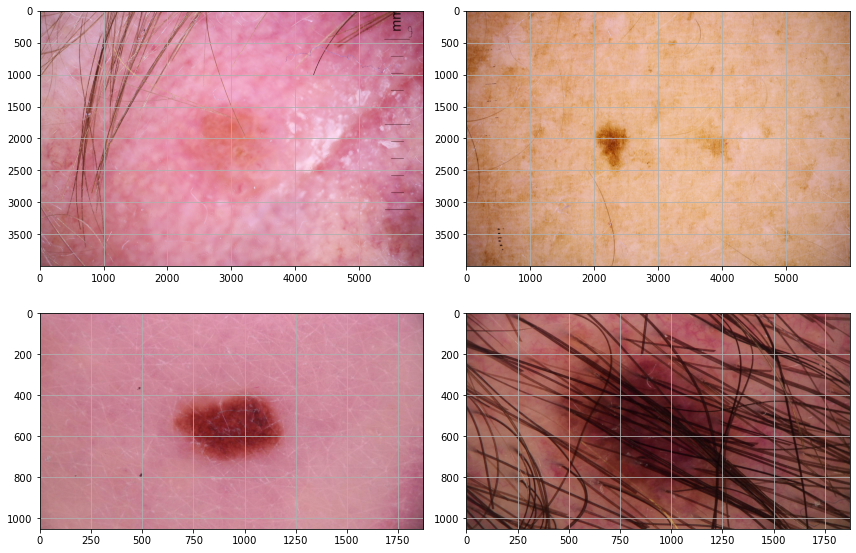

In [17]:
sample_images = []
plt.figure(figsize = (12, 8))
for i in range(4) : 
    plt.subplot(2, 2, i + 1)
    image = cv2.imread(sample_images_path[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap = "gray")
    plt.grid(True)
    sample_images.append(image)
plt.tight_layout()

# Defining Image Preprocessing Function : 

## Image Resizing : 

In [18]:
def resize(image, SHAPE) : 
    image = cv2.resize(image, SHAPE, interpolation = cv2.INTER_NEAREST)
    return image

## Image Denoising :

Many image smoothing techniques like `Gaussian Blurring`, `Median Blurring` etc were good to some extent in removing small quantities of noise. In those techniques, we took a small neighbourhood around a pixel and performed some operations like gaussian weighted average, median of the values etc to replace the central element. In short, noise removal at a pixel was local to its neighbourhood.

There is a property of noise. **Noise is generally considered to be a random variable with zero mean**.

Suppose we hold a static camera to a certain location for a couple of seconds. This will give us plenty of frames, or a lot of images of the same scene. Then averaging all the frames, we compare the final result and first frame. Reduction in noise would be easily observed.

So idea is simple, we need a set of similar images to average out the noise. Considering a small window (say 5x5 window) in the image, chance is large that the same patch may be `somewhere` else in the image. Sometimes in a small neighbourhood around it. Hence, using these `similar patches` together `averaging` them can lead to an `efficient denoised image`.

**This method is Non-Local Means Denoising. It takes more time compared to blurring techniques, but the result are very satisfying**.

For illustration : 

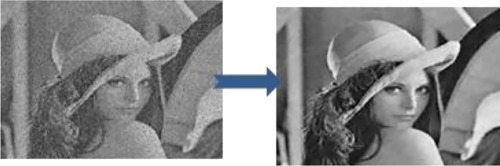 

**OpenCV implementation of the aforementioned approach** :

* **cv2.fastNlMeansDenoisingColored()** - Works on Colored images 
* **cv2.fastNlMeansDenoising()** - Works on grayscale images

Common arguments are:

* **h** : parameter deciding `filter strength`. Higher h value removes noise better, but removes details of image also. (10 is ok)
* **hForColorComponents** : same as h, but for color images only. (normally same as h)
* **templateWindowSize** : should be odd. (recommended 7)
* **searchWindowSize** : should be odd. (recommended 21)

In [19]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

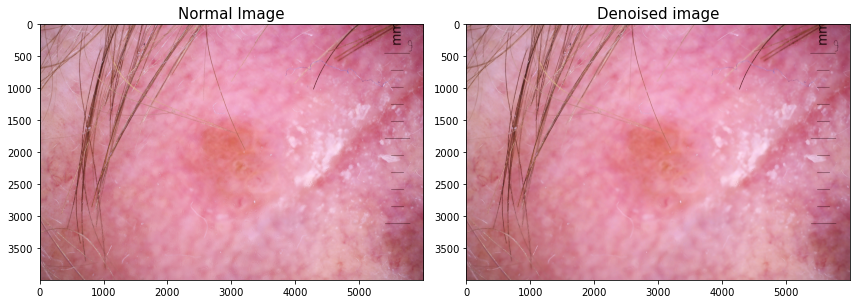

In [20]:
image = sample_images[0]
denoised_image = non_local_means_denoising(image)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image", fontsize = 15)

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image", fontsize = 15)    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout() 

## Local Histogram Pre-Processing

First of all, why can't we apply histogram equalization directly to an RGB image? Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is incorrect. *Equalization involves intensity values of the image, not the color components*.

So for a simple RGB color image, histogram equalization cannot be applied directly on the channels.*It needs to be applied in such a way that the intensity values are equalized without disturbing the color balance of the image*. 

So, the `first step` is to **convert the color space of the image from RGB into one of the color spaces that separates intensity values from color components**. Some of the possible options are HSV/HLS, YUV, YCbCr, etc. YCbCr is preferred as it is designed for digital images.

In `step 2` perform histogram equalization on the intensity plane Y. Now convert the resultant YCbCr image back to RGB.

(Excerpt taken from :

**https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/** )

An illustration of histogram equalization : Observe the intensity difference

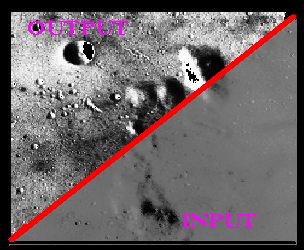 

In [21]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:, :, 0] # apply local histogram processing on this channel
    cr_channel = image_ycrcb[:, :, 1]
    cb_channel = image_ycrcb[:, :, 2]
    
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8,8))
    equalized_channel = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized_channel, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image
    

In [22]:
equalized_image = histogram_equalization(denoised_image)

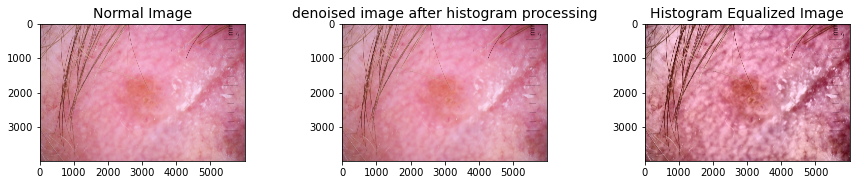

In [23]:
plt.figure(figsize = (12, 8))
plt.subplot(1,3,1)
plt.imshow(image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image", fontsize = 14)

plt.subplot(1,3,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("denoised image after histogram processing", fontsize = 14)

plt.subplot(1,3,3)  
plt.imshow(equalized_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram Equalized Image", fontsize = 14)
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

# Label Encoding of String Values : 

Combining training and testing dataframes.

A chained argument reset_index(drop=True) is passed which drops the current index of the DataFrame and replaces it with an index of increasing integers. It never drops columns. 

In [24]:
combined_dataframe = pd.concat([train[test.columns], test[test.columns]], ignore_index = True, axis = 0).reset_index(drop = True)

print("Shape of combined dataframe = {}".format(combined_dataframe.shape))

Shape of combined dataframe = (44108, 5)


In [25]:
combined_dataframe.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,IP_7279968,male,45.0,head/neck
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity
3,ISIC_0068279,IP_6890425,female,45.0,head/neck
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity


In [26]:
combined_dataframe["age_approx"] = combined_dataframe.age_approx.astype("int")
combined_dataframe.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,IP_7279968,male,45,head/neck
1,ISIC_0015719,IP_3075186,female,45,upper extremity


`Using .factorize() of Pandas for encoding` : 

This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values. 

In [27]:
columns_to_encode = ["patient_id", "sex", "anatom_site_general_challenge"]

for column in columns_to_encode : 
    combined_dataframe[column], unique = combined_dataframe[column].factorize()
    print(unique)

Index(['IP_7279968', 'IP_3075186', 'IP_2842074', 'IP_6890425', 'IP_8723313',
       'IP_2950485', 'IP_4698288', 'IP_6017204', 'IP_7622888', 'IP_5075533',
       ...
       'IP_9047138', 'IP_0982737', 'IP_5067246', 'IP_8434843', 'IP_9720911',
       'IP_9891374', 'IP_2906548', 'IP_7260822', 'IP_9671014', 'IP_6528515'],
      dtype='object', length=2746)
Index(['male', 'female'], dtype='object')
Index(['head/neck', 'upper extremity', 'lower extremity', 'torso',
       'palms/soles', 'oral/genital'],
      dtype='object')


In [28]:
combined_dataframe.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_2637011,0,0,45,0
1,ISIC_0015719,1,1,45,1


Rewriting data to OG dataframes.

In [29]:
train[test.columns] = combined_dataframe.loc[: len(train)-1, test.columns].values
test[test.columns] = combined_dataframe.loc[len(train) : , test.columns].values

print("Shape of train = {}".format(train.shape))
print("Shape of test = {}".format(test.shape))

Shape of train = (33126, 6)
Shape of test = (10982, 5)


In [30]:
train.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,target
0,ISIC_2637011,0,0,45,0,0
1,ISIC_0015719,1,1,45,1,0


In [31]:
test.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,2056,0,70,3
1,ISIC_0052349,2057,0,40,2


So, it's encoded!!

# TFRecord : 

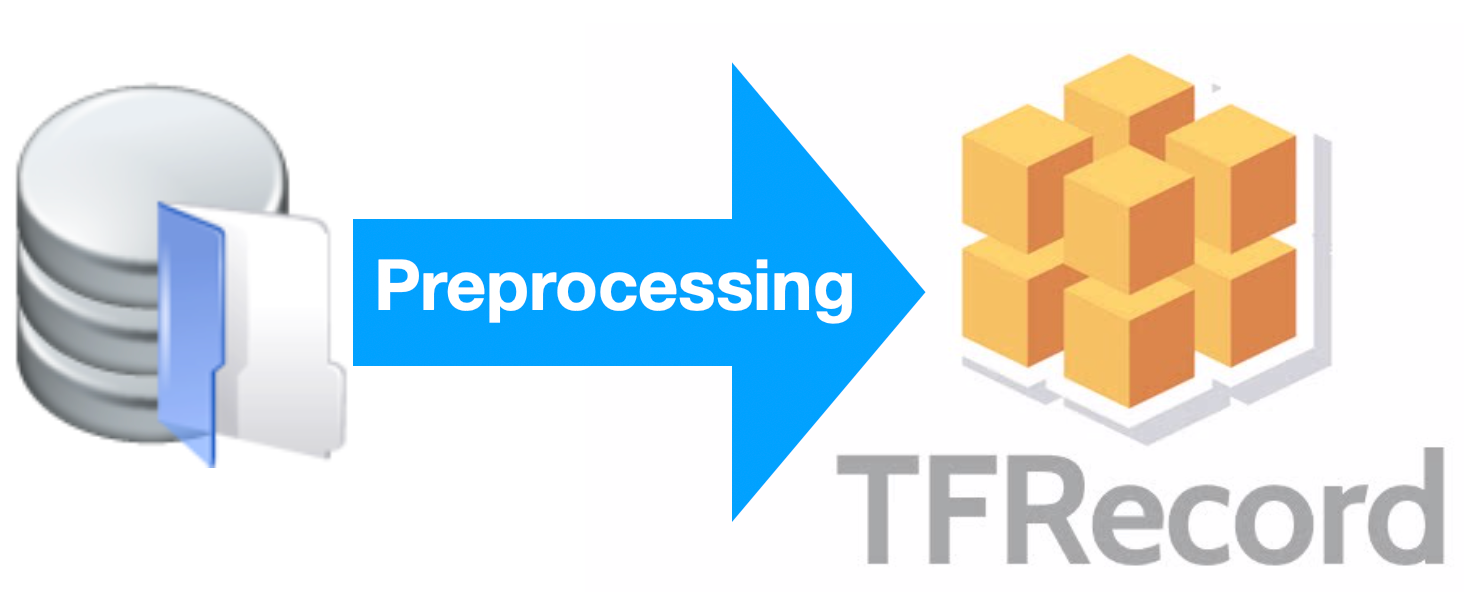 

TF record is Tensorflow's binary storage format for your data.

A TFRecord file contains an array of `Examples`. `Example` is a *data structure for representing a record*, like an observation in a training or test dataset. A record is represented as a set of features, each of which has a name and can be an array of bytes, floats, or 64-bit integers.

To summarize : 

* An Example contains Features.
* Features is a mapping from the feature names stored as strings to Features.

These relations are defined in `example.proto` and `feature.proto` in the TensorFlow's source code, along with extensive comments. As the extension .proto suggests, these definitions are based on `protocol buffers`.

**********************

## Why Protocol Buffers?

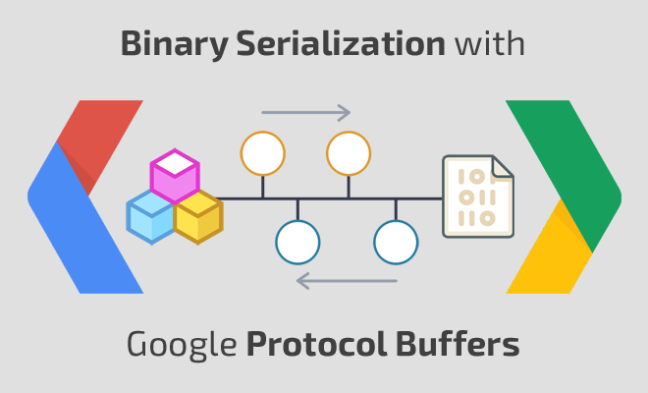

Google’s Protocol buffers are a serialization scheme for structured data. In other words, protocol buffers are used for serializing structured data into a byte array, so that they can be sent over the network or stored as a file. In this sense, it is similar to JSON, XML.

`Protocol buffers can offer a lot faster processing speed compared to text-based formats like JSON or XML`.

**********************

# Writing TFRecord - Train

* `isinstance() function` : Returns True if the specified object is of the specified type, otherwise False. Here, say in the first function tf.constant(0) is `tensorflow.python.framework.ops.EagerTensor`. If passed value happens to be of this type, then True will be retured.

In [32]:
def bytes_features(value) : 
    """
    Returns a bytes_list from a string / byte.
    """
    if isinstance(value, type(tf.constant(0))) :  
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

In [33]:
def float_features(value) : 
    """
    Returns a float_list from a float / double.
    """
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))

In [34]:
def int64_features(value) : 
    """
    Returns an int64_list from a bool / enum / int / uint.
    """
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

Remember, what we said earlier. A TFRecord files is a tensor of records, which are represented using `Example` data structure. This data structure is nothing more than a compilation of `faetures` which map the OG string features to TF compatible feature format.

This is what we are gonna do now. We define a set of features and encapsulate them in an `Example` data structure.

In [35]:
"""
def serialize_example(features_list) : 
    feature = {"image" : bytes_features(features_list[0]),
               "image_name" : bytes_features(features_list[1]),
               "patient_id" : int64_features(features_list[2]),
               "sex" : int64_features(features_list[3]),
               "age_approx" : int64_features(features_list[4]),
               "anatom_site_general_challenge" : int64_features(features_list[5]),
               "target" : int64_features(features_list[6])                   
            }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))
    return example_proto.SerializeToString()
"""

'\ndef serialize_example(features_list) : \n    feature = {"image" : bytes_features(features_list[0]),\n               "image_name" : bytes_features(features_list[1]),\n               "patient_id" : int64_features(features_list[2]),\n               "sex" : int64_features(features_list[3]),\n               "age_approx" : int64_features(features_list[4]),\n               "anatom_site_general_challenge" : int64_features(features_list[5]),\n               "target" : int64_features(features_list[6])                   \n            }\n    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))\n    return example_proto.SerializeToString()\n'

In [36]:
#SIZE = 2071

In [37]:
"""
total_chunks = len(images_in_training_path)//SIZE + int(len(images_in_training_path)%SIZE != 0)
total_chunks
"""

'\ntotal_chunks = len(images_in_training_path)//SIZE + int(len(images_in_training_path)%SIZE != 0)\ntotal_chunks\n'

In [38]:
"""
for j in tqdm(range(total_chunks)) : 
    print("\n Writing TFRecord %i of %i"%(j, total_chunks))
    count = min(SIZE, len(images_in_training_path) - j* SIZE)
    with tf.io.TFRecordWriter("train%.2i-%i.tfrec"%(j, count)) as writer : 
        
        This will be saved as train00-2071.tfrec (for illustration) where the numeral before hyphen is simply 
        a part of name whereas post hyphen denotes number of entries in this record. Here, 2071 entries are in
        the record. 
        
        
        for k in range(count) : 
            image = cv2.imread(path_train + images_in_training_path[SIZE*j + k])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # openCV reads images in BGR format
            image = resize(image, (256, 256))
            image = non_local_means_denoising(image)
            image = histogram_equalization(image)
            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
            
            name = images_in_training_path[SIZE*j+k].split(".")[0]
            row = train.loc[train.image_name == name]
            
            features_list = [image, str.encode(name), row.patient_id.values[0], row.sex.values[0],
                            row.age_approx.values[0], row.anatom_site_general_challenge.values[0],
                           row.target.values[0]]
            
            example = serialize_example(features_list)
            writer.write(example)
            
            if k%100 == 0 :
                print(k,",", end =" ") # end = " " will print everything in a single line.
"""

'\nfor j in tqdm(range(total_chunks)) : \n    print("\n Writing TFRecord %i of %i"%(j, total_chunks))\n    count = min(SIZE, len(images_in_training_path) - j* SIZE)\n    with tf.io.TFRecordWriter("train%.2i-%i.tfrec"%(j, count)) as writer : \n        \n        This will be saved as train00-2071.tfrec (for illustration) where the numeral before hyphen is simply \n        a part of name whereas post hyphen denotes number of entries in this record. Here, 2071 entries are in\n        the record. \n        \n        \n        for k in range(count) : \n            image = cv2.imread(path_train + images_in_training_path[SIZE*j + k])\n            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # openCV reads images in BGR format\n            image = resize(image, (256, 256))\n            image = non_local_means_denoising(image)\n            image = histogram_equalization(image)\n            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()\n            \n        

In [39]:
gc.collect()

7112

Similarily perform everything for testing set also.

# Writing TFRecord - Test

In [40]:
def serialize_example_test(features_list) : 
    feature = {"image" : bytes_features(features_list[0]),
               "image_name" : bytes_features(features_list[1]),
               "patient_id" : int64_features(features_list[2]),
               "sex" : int64_features(features_list[3]),
               "age_approx" : int64_features(features_list[4]),
               "anatom_site_general_challenge" : int64_features(features_list[5]),                
            }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))
    return example_proto.SerializeToString()

In [41]:
SIZE = 687

In [42]:
total_chunks = len(images_in_testing_path)//SIZE + int(len(images_in_testing_path)%SIZE != 0)
total_chunks

16

In [43]:
j = 0 
for j in tqdm(range(total_chunks)) : 
    print("\n Writing TFRecord %i of %i"%(j, total_chunks))
    count = min(SIZE, len(images_in_testing_path) - j* SIZE)
    with tf.io.TFRecordWriter("test%.2i-%i.tfrec"%(j, count)) as writer : 
        """
        This will be saved as test00-2071.tfrec (for illustration) where the numeral before hyphen is simply 
        a part of name whereas post hyphen denotes number of entries in this record. Here, 2071 entries are in
        the record. 
        """
        
        for k in range(count) : 
            image = cv2.imread(path_test + images_in_testing_path[SIZE*j + k])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # openCV reads images in BGR format
            image = resize(image, (256, 256))
            image = non_local_means_denoising(image)
            image = histogram_equalization(image)
            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
            
            name = images_in_testing_path[SIZE*j+k].split(".")[0]
            row = test.loc[test.image_name == name]
            
            features_list = [image, str.encode(name), row.patient_id.values[0], row.sex.values[0],
                            row.age_approx.values[0], row.anatom_site_general_challenge.values[0],
                           ]
            
            example = serialize_example_test(features_list)
            writer.write(example)
            
            if k%100 == 0 :
                print(k,",", end =" ") # end = " " will print everything in a single line.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



 Writing TFRecord 0 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 1 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 2 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 3 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 4 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 5 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 6 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 7 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 8 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 9 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 10 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 11 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 12 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 13 of 16
0 , 100 , 200 , 300 , 400 , 500 , 600 , 
 Writing TFRecord 14 of 16
0 , 100 , 200 , 300 , 400 , 50